In [1]:
from openai import OpenAI
client = OpenAI(
    base_url = 'http://localhost:11434/v1',
    api_key='ollama', # requiAred, but unused
)


json_completion = client.chat.completions.create(
    model="llama3:latest",
    # response_format= { "type": "json_schema","json_schema": json_struct},
    messages=[
            {"role": "system", "content": "hi"},
            # {"role": "user", "content": },
    ],
    temperature=0.2,
    )
json_completion    

ChatCompletion(id='chatcmpl-682', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Hi! It's nice to meet you. Is there something I can help you with, or would you like to chat?", refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None))], created=1746562823, model='llama3:latest', object='chat.completion', service_tier=None, system_fingerprint='fp_ollama', usage=CompletionUsage(completion_tokens=26, prompt_tokens=11, total_tokens=37, completion_tokens_details=None, prompt_tokens_details=None))

In [2]:


template = "you are a expert at classifying topics and rating sentiments on a 5 point scale ( 1 very negative, 2 is negative, 3 neutral, 4 positive, 5 very positive) for crypto curriency posts on reddit. the text into units of thought you have been given the following post to ive a classification and sentiment:"

input_text = "Trump coin seems like something is not right. Now i don't really like politics at all so let's not tlk about that. But why are there 4 trump coins on dextools that have same contract address? And why don't all the transactions show up on trump coin? Literally I've been looking at it and it's like something is fishy about the coin. It's almost like they have admin access to dextools. Anyone else know why there are 4 trump coins w same ca and it doesn't list every buy or sell? "


In [4]:




from pydantic import BaseModel, Field
from typing import List, Dict

class Thought(BaseModel):
        quoted_chunk: str = Field(..., description="the quoted unit of thought")
        thought_classification: str= Field(..., description="the topic classification for the thought")
        thought_classification_explanation: str= Field(..., description="explantion behind the classification")
        thought_sentiment:  int = Field(..., description="the rated sentiment of this thought on 5 point scale 1 very negative, 2 is negative, 3 neutral, 4 positive, 5 very positive")
        positivity: bool = Field(..., description= "True = Positive, False=Negative")
        thought_sentiment_explanation: str = Field(..., description="Sentiment rating 5 point scale, no decimals (1=very negative, 3 neutral, 5=very positive)")
        

class InvestmentPostTopicClassification(BaseModel):
    topic_classification: str = Field(..., description="Primary investment-related topic")
    topic_explanation: str = Field(..., description="Explanation for the assigned topic")
    sentiment_score: int = Field(..., description="Sentiment rating 5 point scale, no decimals (1=very negative, 3 neutral, 5=very positive)")
    sentiment_explanation: str = Field(..., description="Explanation for the sentiment score")
    thoughts: List[Thought]




json_completion = client.beta.chat.completions.parse(
        model="gemma2:9b-instruct-q8_0",
        # response_format= { "type": "json_schema","json_schema": json_struct},
        response_format= InvestmentPostTopicClassification,
        messages=[
                {"role": "user", "content": template},
                # {"role": "user", "content": },            
                {"role": "user", "content": input_text},
        ],
        temperature=0.2,
        )


In [ ]:

import numpy as np

import pickle
import copy
import requests
import os

from pycoingecko import CoinGeckoAPI
from datetime import datetime, timedelta

import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import time
import praw
from pydantic import BaseModel, Field, ValidationError
from typing import List

from dotenv import load_dotenv
import hashlib

import re
import json

# -------------------------------------------------------------------------------------------------------------------------



class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0, bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = .01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.output

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        if self.weight_regularizer_l1 > 0:
            dl1 = np.ones_like(self.weights)
            dl1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dl1
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        if self.bias_regularizer_l1 > 0:
            dl1 = np.ones_like(self.biases)
            dl1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dl1
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs

    def get_parameters(self):
        return self.weights, self.biases

    def set_parameters(self, weights, biases):
        self.weights = weights
        self.biases = biases

class Layer_Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate

    def forward(self, inputs, training):
        self.inputs = inputs
        if not training:
            self.output = inputs.copy()
        else:
            self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
            self.output = inputs * self.binary_mask
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask
        return self.dinputs  # Added return

class Layer_Input:
    def forward(self, inputs, training):
        self.output = inputs
        return self.output





#ACTIVATION # -------------------------------------------------------------------------------------------------------------
#OPTIMIZER # --------------------------------------------------------------------------------------------------------------
#LOSS # -------------------------------------------------------------------------------------------------------------------       
#ACCURACY# ----------------------------------------------------------------------------------------------------------------


class Activation_ReLU:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        return self.dinputs

    def predictions(self, outputs):
        return outputs

class activation_linear:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = inputs
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
    
    def predictions(self, outputs):
        return outputs


 
class Optimizer_adam():
    def __init__(self, learning_rate=.001, decay=0., epsilon=1e-7, beta_1 = .9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate*(1./(1.+self.decay*self.iterations))
    
    def update_params(self, layer):

        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1*layer.weight_momentums + (1-self.beta_1)*layer.dweights
        layer.bias_momentums = self.beta_1*layer.bias_momentums + (1-self.beta_1)*layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / (1-self.beta_1**(self.iterations+1))
        bias_momentums_corrected = layer.bias_momentums / (1-self.beta_1**(self.iterations+1))

        layer.weight_cache = self.beta_2* layer.weight_cache + (1-self.beta_2)*layer.dweights**2
        layer.bias_cache = self.beta_2* layer.bias_cache + (1-self.beta_2)*layer.dbiases**2
        
        weight_cache_corrected = layer.weight_cache / (1-self.beta_2**(self.iterations+1))
        bias_cache_corrected = layer.bias_cache / (1-self.beta_2**(self.iterations+1))


        layer.weights += -self.current_learning_rate*weight_momentums_corrected / (np.sqrt(weight_cache_corrected)+self.epsilon)
        layer.biases += -self.current_learning_rate*bias_momentums_corrected / (np.sqrt(bias_cache_corrected)+self.epsilon)
         
    def post_update_params(self):
        self.iterations += 1




class Loss:
    def regularization_loss(self):
        regularization_loss = 0

        for layer in self.trainable_layers:

            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights*layer.weights)

            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
    
        return regularization_loss

    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers  = trainable_layers

    def calculate(self, output, y, *, include_regularization=False):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)

        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)

        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def calculate_accumulated(self, *, include_regularization=False):
        data_loss = self.accumulated_sum / self.accumulated_count
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0



class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        return sample_losses

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])

        self.dinputs = -2*(y_true - dvalues) / outputs
        self.dinputs = self.dinputs /samples


class Loss_MeanAbsoluteError(Loss):
    def forward(self, y_pred, y_true):
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)
        return sample_losses

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])

        self.dinputs = np.sign(y_true - dvalues) / outputs
        self.dinputs = self.dinputs /samples




def pearson_correlation(y_true, y_pred):
    y_true_mean = np.mean(y_true)
    y_pred_mean = np.mean(y_pred)
    num = np.sum((y_true - y_true_mean) * (y_pred - y_pred_mean))
    denom = np.sqrt(np.sum((y_true - y_true_mean) ** 2) * np.sum((y_pred - y_pred_mean) ** 2))
    return num / denom if denom != 0 else 0

def directional_accuracy(y_true, y_pred):
    direction_correct = np.sign(y_true) == np.sign(y_pred)
    return np.mean(direction_correct)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def simulate_trading(y_true, y_pred, initial_balance=1000, fee=0.001, threshold=0.5):
    """Simulate trading based on predicted price changes."""
    balance = initial_balance
    position = 0  # 0: no position, 1: long
    returns = []
    
    for true_change, pred_change in zip(y_true.flatten(), y_pred.flatten()):
        if pred_change > threshold and position == 0:  # Buy
            position = 1
            balance *= (1 - fee)  # Pay transaction fee
        elif pred_change < -threshold and position == 1:  # Sell
            position = 0
            balance *= (1 - fee) * (1 + true_change / 100)  # Realize true price change
        returns.append(balance)
    
    final_return = (balance - initial_balance) / initial_balance * 100
    return final_return, returns

class Accuracy_Regression:
    def __init__(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0
        self.directional_sum = 0
        self.directional_count = 0
        self.mae_sum = 0
        self.y_min = None
        self.y_max = None

    def init(self, y):
        self.y_min = np.min(y)
        self.y_max = np.max(y)

    def denormalize(self, y):
        """Convert normalized predictions back to percentage price changes."""
        return y * (self.y_max - self.y_min) + self.y_min

    def calculate(self, predictions, y):
        # Denormalize for real-world metrics
        predictions_denorm = self.denormalize(predictions)
        y_denorm = self.denormalize(y)
        
        # Pearson correlation
        correlation = pearson_correlation(y_denorm, predictions_denorm)
        self.accumulated_sum += correlation * len(y)
        self.accumulated_count += len(y)
        
        # Directional accuracy
        dir_acc = directional_accuracy(y_denorm, predictions_denorm)
        self.directional_sum += dir_acc * len(y)
        self.directional_count += len(y)
        
        # Mean absolute error
        mae = mean_absolute_error(y_denorm, predictions_denorm)
        self.mae_sum += mae * len(y)
        
        return correlation, dir_acc, mae

    def calculate_accumulated(self):
        if self.accumulated_count == 0:
            return 0, 0, 0
        return (self.accumulated_sum / self.accumulated_count,
                self.directional_sum / self.directional_count,
                self.mae_sum / self.accumulated_count)

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0
        self.directional_sum = 0
        self.directional_count = 0
        self.mae_sum = 0






#MODEL OBJECT# -------------------------------------------------------------------------------------------------------------------------

class mr_stonks:
    def __init__ (self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)
    
    def set(self, *, loss, optimizer, accuracy):
        if loss is not None:
            self.loss = loss
        if optimizer is not None:
            self.optimizer = optimizer
        if accuracy is not None:
            self.accuracy = accuracy

    def finalize(self):
        self.input_layer = Layer_Input()
        layer_count = len(self.layers)
        self.trainable_layers = []
        for i in range(layer_count):
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]

            elif i<layer_count-1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]

            else:
               self.layers[i].prev = self.layers[i-1] 
               self.layers[i].next = self.loss
               self.output_layer_activation = self.layers[i]
    
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])

        if self.loss is not None:
            self.loss.remember_trainable_layers(self.trainable_layers)
        
    def get_parameters(self):
        parameters=[]
        for layer in self.trainable_layers:
            parameters.append(layer.get_parameters())
        return parameters

    def set_parameters(self, parameters):
        for parameter_set, layer in zip(parameters, self.trainable_layers):
            layer.set_parameters(*parameter_set)


    def train(self, X_train, y_train, X_val, y_val, X_test, y_test, *, epochs=1, batch_size=None, print_every=1, patience=100):
        self.accuracy.init(y_train)
        train_steps = 1
        if batch_size is not None:
            train_steps = len(X_train) // batch_size
            if train_steps * batch_size < len(X_train):
                train_steps += 1
        best_val_loss = float('inf')
        patience_counter = 0
        losses, val_losses, test_losses = [], [], []
        accuracies, val_accuracies, test_accuracies = [], [], []
        trading_returns = []

        for epoch in range(1, epochs+1):
            print(f'epoch: {epoch}')
            self.loss.new_pass()
            self.accuracy.new_pass()

            # Training
            for step in range(train_steps):
                batch_X = X_train if batch_size is None else X_train[step*batch_size:(step+1)*batch_size]
                batch_y = y_train if batch_size is None else y_train[step*batch_size:(step+1)*batch_size]
                output = self.forward(batch_X, training=True)
                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization=True)
                loss = data_loss + regularization_loss
                predictions = self.output_layer_activation.predictions(output)
                accuracy, dir_acc, mae = self.accuracy.calculate(predictions, batch_y)
                self.backward(output, batch_y)
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()
                if not step % print_every or step == train_steps-1:
                    print(f'step: {step}, acc: {accuracy:.3f}, dir_acc: {dir_acc:.3f}, mae: {mae:.3f}, '
                          f'loss: {loss:.3f}, (data_loss: {data_loss:.3f}, reg_loss: {regularization_loss:.3f}, '
                          f'lr: {self.optimizer.current_learning_rate})')

            # Epoch metrics
            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy, epoch_dir_acc, epoch_mae = self.accuracy.calculate_accumulated()
            print(f'training, acc: {epoch_accuracy:.3f}, dir_acc: {epoch_dir_acc:.3f}, mae: {epoch_mae:.3f}, '
                  f'loss: {epoch_loss:.3f}, (data_loss: {epoch_data_loss:.3f}, reg_loss: {epoch_regularization_loss:.3f})')
            losses.append(epoch_loss)
            accuracies.append((epoch_accuracy, epoch_dir_acc, epoch_mae))

            # Validation
            val_loss, (val_acc, val_dir_acc, val_mae) = self.evaluate(X_val, y_val, batch_size=batch_size)
            val_losses.append(val_loss)
            val_accuracies.append((val_acc, val_dir_acc, val_mae))
            print(f'validation, acc: {val_acc:.3f}, dir_acc: {val_dir_acc:.3f}, mae: {val_mae:.3f}, loss: {val_loss:.3f}')

            # Test
            test_loss, (test_acc, test_dir_acc, test_mae) = self.evaluate(X_test, y_test, batch_size=batch_size)
            test_losses.append(test_loss)
            test_accuracies.append((test_acc, test_dir_acc, test_mae))
            print(f'test, acc: {test_acc:.3f}, dir_acc: {test_dir_acc:.3f}, mae: {test_mae:.3f}, loss: {test_loss:.3f}')

            # Trading simulation on validation set
            val_predictions = self.predict(X_val, batch_size=batch_size)
            val_predictions_denorm = self.accuracy.denormalize(val_predictions)
            val_y_denorm = self.accuracy.denormalize(y_val)
            trading_return, _ = simulate_trading(val_y_denorm, val_predictions_denorm)
            trading_returns.append(trading_return)
            print(f'validation trading return: {trading_return:.2f}%')

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save("best_model.pkl")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping")
                    break

        # Final test evaluation
        test_predictions = self.predict(X_test, batch_size=batch_size)
        test_predictions_denorm = self.accuracy.denormalize(test_predictions)
        test_y_denorm = self.accuracy.denormalize(y_test)
        final_trading_return, test_returns = simulate_trading(test_y_denorm, test_predictions_denorm)
        print(f'Final test trading return: {final_trading_return:.2f}%')

        # Plot results
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 2, 1)
        plt.plot(losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.title("Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot([acc[0] for acc in accuracies], label="Training Correlation")
        plt.plot([acc[0] for acc in val_accuracies], label="Validation Correlation")
        plt.plot([acc[0] for acc in test_accuracies], label="Test Correlation")
        plt.title("Pearson Correlation Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Correlation")
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot([acc[1] for acc in accuracies], label="Training Dir Acc")
        plt.plot([acc[1] for acc in val_accuracies], label="Validation Dir Acc")
        plt.plot([acc[1] for acc in test_accuracies], label="Test Dir Acc")
        plt.title("Directional Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Directional Accuracy")
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(trading_returns, label="Validation Trading Return")
        plt.title("Validation Trading Return Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Return (%)")
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Plot test trading returns
        plt.figure(figsize=(10, 5))
        plt.plot(test_returns, label="Test Trading Balance")
        plt.title(f"Test Trading Simulation (Final Return: {final_trading_return:.2f}%)")
        plt.xlabel("Time Step")
        plt.ylabel("Balance ($)")
        plt.legend()
        plt.show()

        return losses, val_losses, test_losses, accuracies, val_accuracies, test_accuracies, trading_returns, final_trading_return

    def evaluate(self, X, y, *, batch_size=None):
        validation_steps = 1
        if batch_size is not None:
            validation_steps = len(X) // batch_size
            if validation_steps * batch_size < len(X):
                validation_steps += 1
        self.loss.new_pass()
        self.accuracy.new_pass()

        for step in range(validation_steps):
            batch_X = X if batch_size is None else X[step*batch_size:(step+1)*batch_size]
            batch_y = y if batch_size is None else y[step*batch_size:(step+1)*batch_size]
            output = self.forward(batch_X, training=False)
            self.loss.calculate(output, batch_y)
            predictions = self.output_layer_activation.predictions(output)
            self.accuracy.calculate(predictions, batch_y)

        loss = self.loss.calculate_accumulated()
        accuracy, dir_acc, mae = self.accuracy.calculate_accumulated()
        return loss, (accuracy, dir_acc, mae)


    def forward(self, X, training):
        self.input_layer.forward(X, training)

        for layer in self.layers:
            layer.forward(layer.prev.output, training)

        return layer.output

    def backward(self, output, y):
        self.loss.backward(output, y)  # Compute loss gradients
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)


    def predict(self, X, *, batch_size=None):
        prediction_steps =1
        if batch_size is not None:
            prediction_steps = len(X) // batch_size
            if prediction_steps*batch_size<len(X):
                prediction_steps+=1
    
        output = []
        for step in range(prediction_steps):
            if batch_size is None:
                batch_X = X
            else:
                batch_X = X[step*batch_size:(step+1)*batch_size]
            batch_output = self.forward(batch_X, training=False)
            output.append(batch_output)

        return np.vstack(output)

    def save_parameters(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self.get_parameters(), f)

    def load_parameters(self, path):
        with open(path, 'rb') as f:
            self.set_parameters(pickle.load(f))

    def save(self, path):
        model = copy.deepcopy(self)
        model.loss.new_pass()
        model.accuracy.new_pass()
        model.input_layer.__dict__.pop('output', None)
        model.loss.__dict__.pop('dinputs', None)
        for layer in model.layers:
            for property in ['inputs', 'output', 'dinputs', 'dweights', 'dbiases']:
                layer.__dict__.pop(property, None)
        with open(path, 'wb') as f:
            pickle.dump(model, f)

    @staticmethod
    def load(path):
        with open(path, 'rb') as f:
            model = pickle.load(f)
            return model


#Data# -------------------------------------------------------------------------------------------------------------------------
# Disclaimer: This script is for personal, non-commercial use only, in compliance with Reddit's API Terms of Use.

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import requests
import os
import praw
import time
import json
import re
import hashlib
from pydantic import BaseModel, Field
from typing import List
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Define meme coin
MEME_COINS = [
    {"id": "official-trump", "reddit_query": "TRUMP OR $TRUMP OR 'Trump Coin' OR 'Official Trump' OR 'meme coin' OR 'Solana meme coin' OR 'Trump token' OR 'Trump meme' OR 'TRUMP coin' OR 'Solana TRUMP' OR crypto OR blockchain OR defi OR solana"}
]

# Date range, use 2 weeks to test functionality
ANALYSIS_START_DATE = datetime(2025, 1, 17).date()
ANALYSIS_END_DATE = datetime(2025, 4, 29).date()

# Pydantic model
class InvestmentPostTopicClassification(BaseModel):
    topic_classification: str = Field(..., description="Primary investment-related topic")
    full_text: str = Field(..., description="The exact text of the post")
    topic_explanation: str = Field(..., description="Explanation for the assigned topic")
    sentiment_score: float = Field(..., ge=0, le=5, description="Sentiment rating (0=very negative, 5=very positive)")
    sentiment_explanation: str = Field(..., description="Explanation for the sentiment score")
    related_investment_topics: List[str] = Field(default_factory=list, description="List of related investment topics")

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def anonymize_username(username):
    return hashlib.sha256(username.encode()).hexdigest() if username else "anonymous"

def fetch_price_data(coin_id, start_date, end_date):
    start_time = time.time()
    coingecko_api_key = os.getenv("COINGECKO_API_KEY")
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range"
    params = {
        'vs_currency': 'usd',
        'from': int(datetime.combine(start_date, datetime.min.time()).timestamp()),
        'to': int(datetime.combine(end_date, datetime.min.time()).timestamp())
    }
    headers = {'x-cg-demo-api-key': coingecko_api_key} if coingecko_api_key else {}
    
    try:
        response = requests.get(url, params=params, headers=headers, timeout=10)
        response.raise_for_status()
        data = response.json()
        prices = {datetime.fromtimestamp(price[0] / 1000).date(): price[1] for price in data['prices']}
        # Ensure end_date is included
        if end_date not in prices and prices:
            last_date = max(prices.keys())
            prices[end_date] = prices[last_date]
        print(f"Fetched {len(prices)} price points for {coin_id} from {min(prices.keys())} to {max(prices.keys())}")
        print(f"Price fetching took {time.time() - start_time:.2f} seconds")
        return prices
    except Exception as e:
        print(f"Error fetching price data for {coin_id}: {e}")
        with open("coingecko_errors.log", "a", encoding='utf-8') as f:
            f.write(f"Error for {coin_id} from {start_date} to {end_date}: {e}\n")
        return {}

def find_peak_price(prices):
    if not prices:
        print("No prices available to find peak")
        return None, None
    dates, values = zip(*prices.items())
    peak_price = max(values)
    peak_date = dates[values.index(peak_price)]
    print(f"Peak price found: ${peak_price:.2f} on {peak_date}")
    min_date = min(dates)
    max_date = max(dates)
    adjusted_start = max(ANALYSIS_START_DATE, min_date)
    adjusted_end = min(ANALYSIS_END_DATE, max_date)
    print(f"Adjusted price window: {adjusted_start} to {adjusted_end}")
    return peak_date, peak_price

def get_earliest_date(prices, start_date):
    if not prices:
        print("No prices available, using analysis_start_date")
        return start_date
    earliest = max(min(prices.keys()), start_date)
    print(f"Earliest date: {earliest}")
    return earliest

def scrape_reddit_posts(query, start_date, end_date, max_posts=10000, subreddit="CryptoCurrency+WallStreetBets+Solana+CryptoMarkets+CryptoMoonShots+SatoshiStreetBets+Crypto+Memecoin+CryptoAll+Defi"):
    print(f"Checking cache for posts for {query} from {start_date} to {end_date} in {subreddit}")
    cache_file = "meme_coin_posts.json"
    
    if os.path.exists(cache_file):
        try:
            with open(cache_file, 'r', encoding='utf-8') as f:
                cached_posts = json.load(f)
            cached_start = datetime.strptime(cached_posts.get('start_date'), '%Y-%m-%d').date()
            cached_end = datetime.strptime(cached_posts.get('end_date'), '%Y-%m-%d').date()
            cached_subreddit = cached_posts.get('subreddit', '')
            cached_posts_list = cached_posts.get('posts', [])
            valid_posts = [p for p in cached_posts_list if 'sentiment_score' in p and 0 <= p['sentiment_score'] <= 5]
            print(f"Cache file contains {len(cached_posts_list)} posts, {len(valid_posts)} with valid sentiments")
            if cached_start == start_date and cached_end == end_date and cached_subreddit == subreddit and len(cached_posts_list) >= 100:
                print(f"Loaded {len(cached_posts_list)} cached posts from {cache_file}")
                return cached_posts_list
            else:
                print(f"Cache invalid: Expected {start_date} to {end_date} in {subreddit}, got {cached_start} to {cached_end} in {cached_subreddit} with {len(cached_posts_list)} posts")
        except Exception as e:
            print(f"Error loading cached posts: {e}")
            with open("cache_errors.log", "a", encoding='utf-8') as f:
                f.write(f"Error loading {cache_file}: {e}\n")
    
    print(f"No valid cache found, attempting to scrape posts")
    reddit = praw.Reddit(
        client_id=os.getenv("REDDIT_CLIENT_ID"),
        client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
        user_agent="script:meme_coin_predictor:v1.0 (by u/Big_Seesaw_5202)"
    )
    posts = []
    max_posts_per_day = 50 
    daily_posts_dict = defaultdict(list)
    retries = 3
    
    for attempt in range(retries):
        try:
            start_time = time.time()
            for submission in reddit.subreddit(subreddit).new(limit=max_posts):
                time.sleep(0.05)
                try:
                    submission_date = datetime.fromtimestamp(submission.created_utc).date()
                    if submission_date < start_date or submission_date > end_date:
                        continue
                    title = remove_emojis(submission.title)
                    selftext = remove_emojis(submission.selftext)
                    text_lower = title.lower() + " " + selftext.lower()
                    if any(term in text_lower for term in ['trump', 'coin', 'token', 'meme', 'solana', 'crypto', 'sol', 'blockchain', 'defi', 'web3']):
                        daily_posts_dict[submission_date].append({
                            "text": title + " " + selftext,
                            "timestamp": datetime.fromtimestamp(submission.created_utc).strftime("%b %d, %Y %I:%M %p"),
                            "username": anonymize_username(submission.author.name if submission.author else None),
                            "upvotes": submission.score,
                            "num_comments": submission.num_comments,
                            "interactions": submission.score + submission.num_comments
                        })
                except Exception as e:
                    print(f"Error processing submission: {e}")
                    continue
            
            for date, daily_posts in daily_posts_dict.items():
                daily_posts = sorted(daily_posts, key=lambda x: x["interactions"], reverse=True)[:max_posts_per_day]
                posts.extend(daily_posts)
                print(f"Collected {len(daily_posts)} posts for {date}")
            
            unique_posts = sorted(
                [dict(t) for t in {tuple(sorted(d.items())) for d in posts}],
                key=lambda x: x["interactions"],
                reverse=True
            )[:max_posts_per_day * ((end_date - start_date).days + 1)]
            
            cache_data = {
                "start_date": start_date.strftime('%Y-%m-%d'),
                "end_date": end_date.strftime('%Y-%m-%d'),
                "subreddit": subreddit,
                "posts": unique_posts
            }
            with open(cache_file, 'w', encoding='utf-8') as f:
                json.dump(cache_data, f, ensure_ascii=False, indent=2)
            print(f"Saved {len(unique_posts)} Reddit posts to {cache_file}")
            print(f"Scraping took {time.time() - start_time:.2f} seconds")
            
            if len(unique_posts) < 100:
                print(f"Warning: Only {len(unique_posts)} posts scraped. Consider broadening query or checking API credentials.")
            
            return unique_posts
        except Exception as e:
            print(f"Scraping attempt {attempt+1} failed: {e}")
            with open("reddit_errors.log", "a", encoding='utf-8') as f:
                f.write(f"Error for query '{query}' from {start_date} to {end_date}: {e}\n")
            if attempt < retries - 1:
                time.sleep(5)
            continue
    
    print(f"All scraping attempts failed. Returning empty post list.")
    return []

def get_vader_sentiment(post_text, query):
    raw_text = post_text
    clean_text = remove_emojis(raw_text)
    start_time = time.time()
    try:
        analyzer = SentimentIntensityAnalyzer()
        title = clean_text.split('\n')[0] if '\n' in clean_text else clean_text
        body = clean_text[len(title):].strip() if len(clean_text) > len(title) else ""
        title_scores = analyzer.polarity_scores(title)
        body_scores = analyzer.polarity_scores(body) if body else {'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
        compound = 0.6 * title_scores['compound'] + 0.4 * body_scores['compound']
        sentiment_score = 2.5 + compound * 2.5
        if abs(sentiment_score - 3.0) < 0.2:
            sentiment_score = 2.5 if sentiment_score < 3.0 else 3.5
        explanation = (
            f"VADER weighted compound: {compound:.2f} (title: {title_scores['compound']:.2f}, body: {body_scores['compound']:.2f})\n"
            f"Title pos: {title_scores['pos']:.2f}, neu: {title_scores['neu']:.2f}, neg: {title_scores['neg']:.2f}\n"
            f"Body pos: {body_scores['pos']:.2f}, neu: {body_scores['neu']:.2f}, neg: {body_scores['neg']:.2f}"
        )
        analysis = InvestmentPostTopicClassification(
            topic_classification="Meme Coin Discussion",
            full_text=clean_text,
            topic_explanation="Post discusses a meme coin",
            sentiment_score=sentiment_score,
            sentiment_explanation=explanation,
            related_investment_topics=[query]
        )
        print(f"VADER raw text: '{raw_text[:100]}...'")
        print(f"VADER clean text: '{clean_text[:100]}...'")
        print(f"VADER text length: {len(clean_text)} characters")
        print(f"VADER weighted compound: {compound:.2f}, title: {title_scores['compound']:.2f}, body: {title_scores['compound']:.2f}")
        print(f"VADER sentiment score: {sentiment_score:.2f} for '{clean_text[:50]}...', took {time.time() - start_time:.2f} seconds")
        return analysis
    except Exception as e:
        print(f"VADER sentiment failed for '{clean_text[:50]}...': {e}")
        with open("sentiment_errors.log", "a", encoding='utf-8') as f:
            f.write(f"VADER failed for post '{clean_text[:50]}...': {e}\n")
        return InvestmentPostTopicClassification(
            topic_classification="Meme Coin Discussion",
            full_text=clean_text,
            topic_explanation="Post discusses a meme coin",
            sentiment_score=3.0,
            sentiment_explanation="Neutral fallback due to VADER failure",
            related_investment_topics=[query]
        )

def process_post(post, query):
    analysis = get_vader_sentiment(post["text"], query)
    post["sentiment_score"] = analysis.sentiment_score
    post["sentiment_explanation"] = analysis.sentiment_explanation
    return post

def preprocess_data(posts, prices, price_start_date, price_end_date, coin_id):
    start_time = time.time()
    if price_end_date < price_start_date:
        print(f"Invalid date range for {coin_id}")
        return np.array([]), np.array([])
    
    daily_sentiment = {}
    daily_volume = {}
    daily_comments = {}
    date_counts = defaultdict(int)
    
    print(f"Starting preprocessing for {len(posts)} posts for {coin_id} from {price_start_date} to {price_end_date}")
    for post in posts:
        try:
            date = datetime.strptime(post["timestamp"], "%b %d, %Y %I:%M %p").date()
            date_counts[date] += 1
            if price_start_date <= date <= price_end_date:
                sentiment_score = post["sentiment_score"]
                upvotes = max(post.get("upvotes", 1), 1)
                num_comments = post.get("num_comments", 0)
                
                print(f"Post on {date}: Sentiment={sentiment_score:.2f}, Upvotes={upvotes}, Comments={num_comments}, Text='{post['text'][:50]}...'")
                
                if date not in daily_sentiment:
                    daily_sentiment[date] = []
                    daily_volume[date] = 0
                    daily_comments[date] = 0
                daily_sentiment[date].append(sentiment_score)
                daily_volume[date] += upvotes
                daily_comments[date] += num_comments
            else:
                print(f"Skipping post on {date}: Outside price window {price_start_date} to {price_end_date}")
        except Exception as e:
            print(f"Error processing post: {e}, Text='{post['text'][:50]}...'")
            with open("preprocess_errors.log", "a", encoding='utf-8') as f:
                f.write(f"Error processing post for {coin_id} on {post.get('timestamp', 'unknown')}: {e}\n")
            continue
    
    print("Post counts by date:")
    for date, count in sorted(date_counts.items()):
        print(f"{date}: {count} posts")
    
    # Smooth sentiment scores (3-day moving average)
    smoothed_sentiment = {}
    for date in sorted(daily_sentiment.keys()):
        window_dates = [date - timedelta(days=d) for d in range(-1, 2) if date - timedelta(days=d) in daily_sentiment]
        window_scores = [score for d in window_dates for score in daily_sentiment[d]]
        smoothed_sentiment[date] = np.mean(window_scores) if window_scores else daily_sentiment[date][0]
    
    X, y = [], []
    current_date = price_start_date
    price_changes = []
    while current_date <= price_end_date:
        try:
            if current_date in prices:
                if current_date in smoothed_sentiment:
                    avg_sentiment = smoothed_sentiment[current_date]
                    post_volume = np.log1p(daily_volume.get(current_date, 1))
                    comment_volume = np.log1p(daily_comments.get(current_date, 0))
                else:
                    print(f"No posts for {current_date}, using neutral sentiment")
                    avg_sentiment = 3.0
                    post_volume = np.log1p(1)
                    comment_volume = np.log1p(0)
                prev_price = prices.get(current_date - timedelta(days=1), prices[current_date])
                price_change = (prices[current_date] - prev_price) / prev_price * 100
                X.append([avg_sentiment, post_volume, comment_volume])
                y.append([price_change])
                price_changes.append(price_change)
                print(f"Data point added for {current_date}: sentiment={avg_sentiment:.2f}, volume={post_volume:.2f}, comments={comment_volume:.2f}, price_change={price_change:.2f}%")
            else:
                print(f"Skipping {current_date} for {coin_id}: No price data")
            current_date += timedelta(days=1)
        except Exception as e:
            print(f"Error generating data point for {current_date}: {e}")
            with open("preprocess_errors.log", "a", encoding='utf-8') as f:
                f.write(f"Error generating data point for {current_date}: {e}\n")
            current_date += timedelta(days=1)
            continue

    X = np.array(X)
    y = np.array(y)
    # Z-score normalize price changes
    if len(price_changes) > 1:
        y = (y - np.mean(price_changes)) / (np.std(price_changes) + 1e-8)
    
    print(f"Preprocessed {len(X)} data points for {coin_id}, X shape: {X.shape}, y shape: {y.shape}")
    if X.shape[0] > 0 and len(X.shape) == 2:
        def pearson_correlation(x, y):
            if len(x) < 2:
                return 0.0
            x_mean, y_mean = np.mean(x), np.mean(y)
            num = np.sum((x - x_mean) * (y - y_mean))
            den = np.sqrt(np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2))
            return num / den if den != 0 else 0.0
        print("Sentiment correlation:", pearson_correlation(X[:, 0], y.flatten()))
        print("Volume correlation:", pearson_correlation(X[:, 1], y.flatten()))
        print("Comment correlation:", pearson_correlation(X[:, 2], y.flatten()))
    print(f"Preprocessing took {time.time() - start_time:.2f} seconds")
    return X, y


def collect_meme_coin_data(coins, analysis_start_date, analysis_end_date):
    all_X, all_y = [], []
    subreddit = "CryptoCurrency+WallStreetBets+Solana+CryptoMarkets+CryptoMoonShots+SatoshiStreetBets+Crypto+Memecoin+CryptoAll+Defi"
    for coin in coins:
        coin_id = coin["id"]
        reddit_query = coin["reddit_query"]
        print(f"Processing {coin_id}...")
        
        start_time = time.time()
        prices = fetch_price_data(coin_id, analysis_start_date, analysis_end_date)
        if not prices:
            print(f"No price data for {coin_id}, skipping")
            continue
        
        peak_date, peak_price = find_peak_price(prices)
        if not peak_date:
            print(f"No peak price found for {coin_id}, skipping")
            continue
        earliest_date = get_earliest_date(prices, analysis_start_date)
        
        price_start_date = max(analysis_start_date, earliest_date)
        price_end_date = min(analysis_end_date, max(prices.keys()))
        print(f"Peak price for {coin_id}: ${peak_price:.2f} on {peak_date}")
        print(f"Price data window: {price_start_date} to {price_end_date}")
        
        prices = {k: v for k, v in prices.items() if price_start_date <= k <= price_end_date}

        posts = []
        raw_posts = scrape_reddit_posts(reddit_query, analysis_start_date, analysis_end_date, max_posts=10000, subreddit=subreddit)
        print(f"Fetched {len(raw_posts)} raw posts for query '{reddit_query}'")
        
        if not raw_posts:
            print(f"No posts fetched for {coin_id}, skipping")
            continue
        
        with ThreadPoolExecutor(max_workers=4) as executor:
            future_to_post = {executor.submit(process_post, post, "TRUMP"): post for post in raw_posts}
            for future in as_completed(future_to_post):
                post = future.result()
                posts.append(post)
                print(f"Processed post: {post['text'][:50]}... (Score: {post['sentiment_score']:.2f})")
        print(f"Processed {len(posts)} posts with sentiment")
        
        cache_file = "meme_coin_posts.json"
        cache_data = {
            "start_date": analysis_start_date.strftime('%Y-%m-%d'),
            "end_date": analysis_end_date.strftime('%Y-%m-%d'),
            "subreddit": subreddit,
            "posts": posts
        }
        with open(cache_file, 'w', encoding='utf-8') as f:
            json.dump(cache_data, f, ensure_ascii=False, indent=2)
        print(f"Updated {cache_file} with {len(posts)} posts including sentiment scores")
        
        X, y = preprocess_data(posts, prices, price_start_date, price_end_date, coin_id)
        if len(X) < 10:
            print(f"Insufficient data points ({len(X)}) for {coin_id}, skipping")
            continue
        
        all_X.append(X)
        all_y.append(y)
        print(f"Processing {coin_id} took {time.time() - start_time:.2f} seconds")
    
    if not all_X or not all_y:
        print("Error: No valid data points collected. Check scraping or price data.")
        return np.array([]), np.array([])
    
    X = np.vstack(all_X)
    y = np.vstack(all_y)
    
    if (X.max(axis=0) == X.min(axis=0)).any():
        print("Warning: Zero range in features, adjusting normalization")
        X = np.where(X.max(axis=0) == X.min(axis=0), 0, (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0) + 1e-8))
    else:
        X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0) + 1e-8)
    
    print(f"Collected {len(X)} total data points, X shape: {X.shape}, y shape: {y.shape}")
    return X, y





# -------------------------------------------------------------------------------------------------------------------------


# Collect and preprocess data
load_dotenv()
X, y = collect_meme_coin_data(MEME_COINS, ANALYSIS_START_DATE, ANALYSIS_END_DATE)

# Check dataset before splitting
if X.size == 0 or y.size == 0:
    print("Error: No valid data points collected for any coin. Check logs for details.")
    exit(1)

print(f"Dataset shapes: X={X.shape}, y={y.shape}")
if len(X.shape) < 2:
    print("Error: X is not 2-dimensional. Using mock data.")
    X = np.array([[3.5, np.log1p(2)], [4.0, np.log1p(3)], [3.0, np.log1p(1)]])
    y = np.array([[1.0], [-0.5], [0.2]])
    print(f"Mock data created: X shape={X.shape}, y shape={y.shape}")

# Split data into train, validation, and test sets
try:
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
    print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")
except ValueError as e:
    print(f"Error splitting data: {e}")
    print("Dataset is invalid. Check data collection logs.")
    exit(1)

def pearson_correlation(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    num = np.sum((x - x_mean) * (y - y_mean))
    denom = np.sqrt(np.sum((x - x_mean) ** 2) * np.sum((y - y_mean) ** 2))
    return num / denom if denom != 0 else 0

# Calculate correlations safely
if X.shape[0] > 0 and len(X.shape) == 2:
    print("Sentiment correlation:", pearson_correlation(X[:, 0], y.flatten()))
    print("Volume correlation:", pearson_correlation(X[:, 1], y.flatten()))
else:
    print("Cannot compute correlations: Invalid dataset shape")




# Define and train model# -------------------------------------------------------------------------------------------------------------------------


model = mr_stonks()
model.add(Layer_Dense(2, 64, weight_regularizer_l2=0.005))
model.add(Activation_ReLU())
model.add(Layer_Dropout(0.2))
model.add(Layer_Dense(64, 32))
model.add(Activation_ReLU())
model.add(Layer_Dense(32, 16))
model.add(Activation_ReLU())
model.add(Layer_Dense(16, 1))
model.add(activation_linear())
model.set(
    loss=Loss_MeanAbsoluteError(),
    optimizer=Optimizer_adam(learning_rate=0.001, decay=1e-4),
    accuracy=Accuracy_Regression()
)
model.finalize()
losses, val_losses, test_losses, accuracies, val_accuracies, test_accuracies, trading_returns, final_trading_return = model.train(
    X_train, y_train, X_val, y_val, X_test, y_test,
    epochs=100,
    batch_size=16,
    print_every=10,
    patience=20
)

In [22]:
from pydantic import BaseModel, Field
from typing import List, Dict

class Interaction(BaseModel):
    AGENT: str = Field(..., description="The dialogue spoken by the agent")
    CLIENT: str = Field(..., description="The dialogue spoken by the client")

class Transcript(BaseModel):
    transcript: List[Interaction] = Field(..., 
        description="The transcript of the conversation, each entry contains both AGENT and CLIENT dialogues")


json_completion = client.beta.chat.completions.parse(
        model="gemma2:9b-instruct-q8_0",
        # response_format= { "type": "json_schema","json_schema": json_struct},
        response_format= Transcript,
        messages=[
                {"role": "user", "content": template},
                {"role": "user", "content": additional_modifications},            
                {"role": "user", "content": input_text},
        ],
        temperature=0.02,
        )
Transcript.validate(json_completion.choices[0].message.parsed)

completion = json_completion.to_dict()        

NameError: name 'template' is not defined

In [ ]:
{"overall_classification": "overal classification",
 "overall_sentiment": "3",
 "Thoughts":[
    {"thought_chunk": "Trump coin seems like something is not right."
     "thought_classification": 'classifcation'
     "thought_sentiment": "2"
    },
    
 ]
}

In [18]:
json_completion = client.beta.chat.completions.parse(
        model="gemma2:9b-instruct-q8_0",
        # response_format= { "type": "json_schema","json_schema": json_struct},
        response_format= InvestmentPostTopicClassification,
        messages=[
                {"role": "user", "content": template},
                # {"role": "user", "content": },            
                {"role": "user", "content": input_text},
        ],
        temperature=0.2,
        )



In [23]:
InvestmentPostTopicClassification.model_validate(json_completion.choices[0].message.parsed)

InvestmentPostTopicClassification(topic_classification='Cryptocurrency Scam Suspicion', topic_explanation='The post expresses concern about a potential scam involving multiple Trump-themed cryptocurrencies sharing the same contract address on DexTools, and questioning the transparency of transactions.', sentiment_score=1, sentiment_explanation="The sentiment is very negative (1) due to the author's skepticism and suspicion about foul play in the Trump coin project. The user explicitly mentions feeling that 'something is fishy' and questions the integrity of the coin's presentation on DexTools.", thoughts=[Thought(thought_chunk='The post author expresses dislike for politics but focuses on a specific cryptocurrency related to Donald Trump.', thought_classification='topic_introduction', thought_classification_explanation="This segment sets the context by stating the author's neutrality towards politics, then shifts focus to a crypto-related topic.", thought_sentiment=3, thought_sentiment

In [32]:
json_completion.to_dict()

{'id': 'chatcmpl-325',
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'content': '{\n"topic_classification": "Cryptocurrency Scam Suspicion",\n"topic_explanation": "The post expresses concern about a potential scam involving multiple Trump-themed cryptocurrencies sharing the same contract address on DexTools, and questioning the transparency of transactions.",\n\n"sentiment_score": 1,\n"sentiment_explanation": "The sentiment is very negative (1) due to the author\'s skepticism and suspicion about foul play in the Trump coin project. The user explicitly mentions feeling that \'something is fishy\' and questions the integrity of the coin\'s presentation on DexTools."\n\n,\n"thoughts": [\n    {\n        "thought_chunk": "The post author expresses dislike for politics but focuses on a specific cryptocurrency related to Donald Trump.",\n        "thought_classification": "topic_introduction"\n    ,\n    "thought_classification_explanation": "This segment sets the contex

In [31]:
json_completion.to_dict()['choices'][0]['message']['parsed']

{'topic_classification': 'Cryptocurrency Scam Suspicion',
 'topic_explanation': 'The post expresses concern about a potential scam involving multiple Trump-themed cryptocurrencies sharing the same contract address on DexTools, and questioning the transparency of transactions.',
 'sentiment_score': 1,
 'sentiment_explanation': "The sentiment is very negative (1) due to the author's skepticism and suspicion about foul play in the Trump coin project. The user explicitly mentions feeling that 'something is fishy' and questions the integrity of the coin's presentation on DexTools.",
 'thoughts': [{'thought_chunk': 'The post author expresses dislike for politics but focuses on a specific cryptocurrency related to Donald Trump.',
   'thought_classification': 'topic_introduction',
   'thought_classification_explanation': "This segment sets the context by stating the author's neutrality towards politics, then shifts focus to a crypto-related topic.",
   'thought_sentiment': 3,
   'thought_senti

In [40]:
json_completion = client.beta.chat.completions.parse(
        model="granite3.3:8b",
        # response_format= { "type": "json_schema","json_schema": json_struct},
        response_format= InvestmentPostTopicClassification,
        messages=[
                {"role": "user", "content": template},
                # {"role": "user", "content": },            
                {"role": "user", "content": input_text},
        ],
        temperature=0.4,
        )

json_completion.to_dict()

{'id': 'chatcmpl-668',
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'content': '{\n"topic_classification": "Cryptocurrency Scam Suspicion",\n"topic_explanation": "The post expresses suspicion about the legitimacy of a cryptocurrency project, specifically a coin named \'Trump Coin\'. The user questions the authenticity due to multiple coins sharing the same contract address and discrepancies in transaction visibility on Dextools.",\n\n"sentiment_score": 1,\n"sentiment_explanation": "The sentiment expressed is very negative (1). The author is clearly skeptical and concerned about potential fraud or manipulation related to this cryptocurrency. They describe their findings as \'fishy\' and express doubt, indicating a strong level of disapproval towards the situation."\n\n,\n"thoughts": [\n    {\n        "quoted_chunk": "Trump coin seems like something is not right.",\n        "thought_classification": "Suspicion",\n        "thought_classification_explanation": "The 

In [38]:
parsed_response = InvestmentPostTopicClassification.model_validate_json(json_completion.choices[0].message.content)
json_completion.to_dict()



{'id': 'chatcmpl-511',
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'content': '{\n  "topic_classification": "Cryptocurrency Scam Suspicion",\n  "topic_explanation": "The post discusses a suspicious situation involving multiple Trump-branded cryptocurrencies sharing the same contract address on Dextools, raising concerns about potential manipulation or fraud.",\n\n  "sentiment_score": 1,\n  "sentiment_explanation": "The sentiment expressed in this post is very negative (1). The user expresses skepticism and concern over what appears to be irregularities with Trump-branded cryptocurrencies, suggesting they suspect a scam or fraudulent activity."\n\n,\n"thoughts": [\n  {\n    "thought_chunk": "The post mentions Trump coin and raises suspicion about its legitimacy.",\n    "thought_classification": "Suspicion of Scam",\n    "thought_classification_explanation": "The user is questioning the authenticity and transparency of the Trump coin project."\n  ,\n  "thought_se

In [33]:
-1


-1

In [2]:

# ------------------------- Neural Network Components -------------------------
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0, bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.output

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        if self.weight_regularizer_l1 > 0:
            dl1 = np.ones_like(self.weights)
            dl1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dl1
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        if self.bias_regularizer_l1 > 0:
            dl1 = np.ones_like(self.biases)
            dl1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dl1
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs

    def get_parameters(self):
        return self.weights, self.biases

    def set_parameters(self, weights, biases):
        self.weights = weights
        self.biases = biases

class Layer_Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate

    def forward(self, inputs, training):
        self.inputs = inputs
        if not training:
            self.output = inputs.copy()
        else:
            self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
            self.output = inputs * self.binary_mask
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask
        return self.dinputs

class Layer_Input:
    def forward(self, inputs, training):
        self.output = inputs
        return self.output

class Activation_ReLU:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        return self.dinputs

    def predictions(self, outputs):
        return outputs

class Activation_Linear:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = inputs
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        return self.dinputs

    def predictions(self, outputs):
        return outputs

class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2

        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

class Loss:
    def regularization_loss(self):
        regularization_loss = 0
        for layer in self.trainable_layers:
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
        return regularization_loss

    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

    def calculate(self, output, y, *, include_regularization=False):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def calculate_accumulated(self, *, include_regularization=False):
        data_loss = self.accumulated_sum / self.accumulated_count
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        return np.mean((y_true - y_pred) ** 2, axis=-1)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

class Accuracy_Regression:
    def __init__(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0
        self.directional_sum = 0
        self.directional_count = 0
        self.mae_sum = 0
        self.y_min = None
        self.y_max = None

    def init(self, y):
        self.y_min = np.min(y)
        self.y_max = np.max(y)

    def denormalize(self, y):
        return y * (self.y_max - self.y_min) + self.y_min

    def calculate(self, predictions, y):
        predictions_denorm = self.denormalize(predictions)
        y_denorm = self.denormalize(y)
        correlation = pearson_correlation(y_denorm, predictions_denorm)
        self.accumulated_sum += correlation * len(y)
        self.accumulated_count += len(y)
        dir_acc = directional_accuracy(y_denorm, predictions_denorm)
        self.directional_sum += dir_acc * len(y)
        self.directional_count += len(y)
        mae = mean_absolute_error(y_denorm, predictions_denorm)
        self.mae_sum += mae * len(y)
        return correlation, dir_acc, mae

    def calculate_accumulated(self):
        if self.accumulated_count == 0:
            return 0, 0, 0
        return (
            self.accumulated_sum / self.accumulated_count,
            self.directional_sum / self.directional_count,
            self.mae_sum / self.accumulated_count
        )

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0
        self.directional_sum = 0
        self.directional_count = 0
        self.mae_sum = 0

def pearson_correlation(y_true, y_pred):
    y_true_mean = np.mean(y_true)
    y_pred_mean = np.mean(y_pred)
    num = np.sum((y_true - y_true_mean) * (y_pred - y_pred_mean))
    denom = np.sqrt(np.sum((y_true - y_true_mean) ** 2) * np.sum((y_pred - y_pred_mean) ** 2))
    return num / denom if denom != 0 else 0

def directional_accuracy(y_true, y_pred):
    direction_correct = np.sign(y_true) == np.sign(y_pred)
    return np.mean(direction_correct)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def simulate_trading(y_true, y_pred, initial_balance=1000, fee=0.001, threshold=0.5):
    balance = initial_balance
    position = 0  # 0: no position, 1: long
    returns = []
    for true_change, pred_change in zip(y_true.flatten(), y_pred.flatten()):
        if pred_change > threshold and position == 0:  # Buy
            position = 1
            balance *= (1 - fee)
        elif pred_change < -threshold and position == 1:  # Sell
            position = 0
            balance *= (1 - fee) * (1 + true_change / 100)
        returns.append(balance)
    final_return = (balance - initial_balance) / initial_balance * 100
    return final_return, returns

class MrStonks:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def set(self, *, loss, optimizer, accuracy):
        self.loss = loss
        self.optimizer = optimizer
        self.accuracy = accuracy

    def finalize(self):
        self.input_layer = Layer_Input()
        layer_count = len(self.layers)
        self.trainable_layers = []
        for i in range(layer_count):
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i + 1]
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.layers[i + 1]
            else:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])
        self.loss.remember_trainable_layers(self.trainable_layers)

    def forward(self, X, training):
        self.input_layer.forward(X, training)
        for layer in self.layers:
            layer.forward(layer.prev.output, training)
        return layer.output

    def backward(self, output, y):
        self.loss.backward(output, y)
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)

    def predict(self, X, *, batch_size=None):
        prediction_steps = 1
        if batch_size is not None:
            prediction_steps = len(X) // batch_size
            if prediction_steps * batch_size < len(X):
                prediction_steps += 1
        output = []
        for step in range(prediction_steps):
            batch_X = X if batch_size is None else X[step * batch_size:(step + 1) * batch_size]
            batch_output = self.forward(batch_X, training=False)
            output.append(batch_output)
        return np.vstack(output)

    def evaluate(self, X, y, *, batch_size=None):
        validation_steps = 1
        if batch_size is not None:
            validation_steps = len(X) // batch_size
            if validation_steps * batch_size < len(X):
                validation_steps += 1
        self.loss.new_pass()
        self.accuracy.new_pass()
        for step in range(validation_steps):
            batch_X = X if batch_size is None else X[step * batch_size:(step + 1) * batch_size]
            batch_y = y if batch_size is None else y[step * batch_size:(step + 1) * batch_size]
            output = self.forward(batch_X, training=False)
            self.loss.calculate(output, batch_y)
            predictions = self.output_layer_activation.predictions(output)
            self.accuracy.calculate(predictions, batch_y)
        loss = self.loss.calculate_accumulated()
        accuracy, dir_acc, mae = self.accuracy.calculate_accumulated()
        return loss, (accuracy, dir_acc, mae)

    def train(self, X_train, y_train, X_val, y_val, X_test, y_test, *, epochs=1, batch_size=None, print_every=1, patience=100):
        self.accuracy.init(y_train)
        train_steps = 1
        if batch_size is not None:
            train_steps = len(X_train) // batch_size
            if train_steps * batch_size < len(X_train):
                train_steps += 1
        best_val_loss = float('inf')
        patience_counter = 0
        losses, val_losses, test_losses = [], [], []
        accuracies, val_accuracies, test_accuracies = [], [], []
        trading_returns = []

        for epoch in range(1, epochs + 1):
            print(f'epoch: {epoch}')
            self.loss.new_pass()
            self.accuracy.new_pass()
            for step in range(train_steps):
                batch_X = X_train if batch_size is None else X_train[step * batch_size:(step + 1) * batch_size]
                batch_y = y_train if batch_size is None else y_train[step * batch_size:(step + 1) * batch_size]
                output = self.forward(batch_X, training=True)
                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization=True)
                loss = data_loss + regularization_loss
                predictions = self.output_layer_activation.predictions(output)
                accuracy, dir_acc, mae = self.accuracy.calculate(predictions, batch_y)
                self.backward(output, batch_y)
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()
                if not step % print_every or step == train_steps - 1:
                    print(f'step: {step}, acc: {accuracy:.3f}, dir_acc: {dir_acc:.3f}, mae: {mae:.3f}, '
                          f'loss: {loss:.3f}, (data_loss: {data_loss:.3f}, reg_loss: {regularization_loss:.3f}, '
                          f'lr: {self.optimizer.current_learning_rate})')
            
            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy, epoch_dir_acc, epoch_mae = self.accuracy.calculate_accumulated()
            print(f'training, acc: {epoch_accuracy:.3f}, dir_acc: {epoch_dir_acc:.3f}, mae: {epoch_mae:.3f}, '
                  f'loss: {epoch_loss:.3f}, (data_loss: {epoch_data_loss:.3f}, reg_loss: {epoch_regularization_loss:.3f})')
            losses.append(epoch_loss)
            accuracies.append((epoch_accuracy, epoch_dir_acc, epoch_mae))

            val_loss, (val_acc, val_dir_acc, val_mae) = self.evaluate(X_val, y_val, batch_size=batch_size)
            val_losses.append(val_loss)
            val_accuracies.append((val_acc, val_dir_acc, val_mae))
            print(f'validation, acc: {val_acc:.3f}, dir_acc: {val_dir_acc:.3f}, mae: {val_mae:.3f}, loss: {val_loss:.3f}')

            test_loss, (test_acc, test_dir_acc, test_mae) = self.evaluate(X_test, y_test, batch_size=batch_size)
            test_losses.append(test_loss)
            test_accuracies.append((test_acc, test_dir_acc, test_mae))
            print(f'test, acc: {test_acc:.3f}, dir_acc: {test_dir_acc:.3f}, mae: {test_mae:.3f}, loss: {test_loss:.3f}')

            val_predictions = self.predict(X_val, batch_size=batch_size)
            val_predictions_denorm = self.accuracy.denormalize(val_predictions)
            val_y_denorm = self.accuracy.denormalize(y_val)
            trading_return, _ = simulate_trading(val_y_denorm, val_predictions_denorm)
            trading_returns.append(trading_return)
            print(f'validation trading return: {trading_return:.2f}%')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save("best_model.pkl")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping")
                    break

        test_predictions = self.predict(X_test, batch_size=batch_size)
        test_predictions_denorm = self.accuracy.denormalize(test_predictions)
        test_y_denorm = self.accuracy.denormalize(y_test)
        final_trading_return, test_returns = simulate_trading(test_y_denorm, test_predictions_denorm)
        print(f'Final test trading return: {final_trading_return:.2f}%')

        plt.figure(figsize=(15, 10))
        plt.subplot(2, 2, 1)
        plt.plot(losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.title("Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot([acc[0] for acc in accuracies], label="Training Correlation")
        plt.plot([acc[0] for acc in val_accuracies], label="Validation Correlation")
        plt.plot([acc[0] for acc in test_accuracies], label="Test Correlation")
        plt.title("Pearson Correlation Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Correlation")
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot([acc[1] for acc in accuracies], label="Training Dir Acc")
        plt.plot([acc[1] for acc in val_accuracies], label="Validation Dir Acc")
        plt.plot([acc[1] for acc in test_accuracies], label="Test Dir Acc")
        plt.title("Directional Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Directional Accuracy")
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(trading_returns, label="Validation Trading Return")
        plt.title("Validation Trading Return Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Return (%)")
        plt.legend()

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(test_returns, label="Test Trading Balance")
        plt.title(f"Test Trading Simulation (Final Return: {final_trading_return:.2f}%)")
        plt.xlabel("Time Step")
        plt.ylabel("Balance ($)")
        plt.legend()
        plt.show()

        return losses, val_losses, test_losses, accuracies, val_accuracies, test_accuracies, trading_returns, final_trading_return

    def save(self, path):
        model = copy.deepcopy(self)
        model.loss.new_pass()
        model.accuracy.new_pass()
        model.input_layer.__dict__.pop('output', None)
        model.loss.__dict__.pop('dinputs', None)
        for layer in model.layers:
            for prop in ['inputs', 'output', 'dinputs', 'dweights', 'dbiases']:
                layer.__dict__.pop(prop, None)
        with open(path, 'wb') as f:
            pickle.dump(model, f)

    @staticmethod
    def load(path):
        with open(path, 'rb') as f:
            return pickle.load(f)


In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
import os
import praw
import time
import json
from datetime import datetime, timedelta
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from pydantic import BaseModel, Field
from typing import List
from dotenv import load_dotenv
import requests
import re
import hashlib
import matplotlib.pyplot as plt
import pickle
import copy
from sklearn.metrics import r2_score
import random


import ollama

# Initialize Ollama client
try:
    client = ollama.Client()
except Exception as e:
    print(f"Failed to initialize Ollama client: {e}")
    client = None


# Load environment variables
load_dotenv()

# ------------------------- Configuration -------------------------
MEME_COINS = [
    {
        "id": "official-trump",
        "reddit_query": "official trump OR trump coin OR $TRUMP OR meme coin"
    }
]
ANALYSIS_START_DATE = datetime(2025, 1, 17).date()
ANALYSIS_END_DATE = datetime(2025, 4, 29).date()
SUBREDDIT = "CryptoCurrency+WallStreetBets+Solana+CryptoMarkets+CryptoMoonShots"
MAX_POSTS = 5000
MAX_POSTS_PER_DAY = 50

# ------------------------- Pydantic Models -------------------------
class Thought(BaseModel):
    quoted_chunk: str = Field(..., description="The quoted unit of thought")
    thought_classification: str = Field(..., description="The topic classification for the thought")
    thought_classification_explanation: str = Field(..., description="Explanation behind the classification")
    thought_sentiment: int = Field(..., description="Sentiment on 5-point scale (1=very negative, 5=very positive)")
    positivity: bool = Field(..., description="True=Positive, False=Negative")
    thought_sentiment_explanation: str = Field(..., description="Explanation for sentiment rating")

class InvestmentPostTopicClassification(BaseModel):
    topic_classification: str = Field(..., description="Primary investment-related topic")
    topic_explanation: str = Field(..., description="Explanation for the assigned topic")
    sentiment_score: int = Field(..., ge=1, le=5, description="Sentiment rating (1=very negative, 5=very positive)")
    sentiment_explanation: str = Field(..., description="Explanation for the sentiment score")
    thoughts: List[Thought] = Field(..., description="List of analyzed thoughts in the post")

# ------------------------- Utility Functions -------------------------
def remove_emojis(text: str) -> str:
    """Remove emojis from text."""
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

def anonymize_username(username: str) -> str:
    """Anonymize username using SHA256 hash."""
    return hashlib.sha256(username.encode()).hexdigest() if username else "anonymous"

# ------------------------- Data Collection -------------------------
def fetch_price_data(coin_id: str, start_date: datetime.date, end_date: datetime.date) -> dict:
    """Fetch historical price data from CoinGecko."""
    start_time = time.time()
    coingecko_api_key = os.getenv("COINGECKO_API_KEY")
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range"
    params = {
        'vs_currency': 'usd',
        'from': int(datetime.combine(start_date, datetime.min.time()).timestamp()),
        'to': int(datetime.combine(end_date, datetime.min.time()).timestamp())
    }
    headers = {'x-cg-demo-api-key': coingecko_api_key} if coingecko_api_key else {}
    
    try:
        response = requests.get(url, params=params, headers=headers, timeout=10)
        response.raise_for_status()
        data = response.json()
        prices = {datetime.fromtimestamp(price[0] / 1000).date(): price[1] for price in data['prices']}
        if end_date not in prices and prices:
            last_date = max(prices.keys())
            prices[end_date] = prices[last_date]
        print(f"Fetched {len(prices)} price points for {coin_id} from {min(prices.keys())} to {max(prices.keys())}")
        print(f"Price fetching took {time.time() - start_time:.2f} seconds")
        return prices
    except Exception as e:
        print(f"Error fetching price data for {coin_id}: {e}")
        with open("coingecko_errors.log", "a", encoding='utf-8') as f:
            f.write(f"Error for {coin_id} from {start_date} to {end_date}: {e}\n")
        return {}

def scrape_reddit_posts(query: str, start_date: datetime.date, end_date: datetime.date, max_posts: int, subreddit: str) -> List[dict]:
    """Scrape Reddit posts matching the query within the date range using search."""
    cache_file = "meme_coin_posts.json"
    print(f"Checking cache for posts for {query} from {start_date} to {end_date} in {subreddit}")
    
    if os.path.exists(cache_file):
        try:
            with open(cache_file, 'r', encoding='utf-8') as f:
                cached = json.load(f)
            if (cached.get('start_date') == start_date.strftime('%Y-%m-%d') and
                cached.get('end_date') == end_date.strftime('%Y-%m-%d') and
                cached.get('subreddit') == subreddit and
                len(cached.get('posts', [])) > 0):
                print(f"Loaded {len(cached['posts'])} cached posts from {cache_file}")
                return cached['posts']
        except Exception as e:
            print(f"Error loading cache: {e}")
            with open("cache_errors.log", "a", encoding='utf-8') as f:
                f.write(f"Error loading {cache_file}: {e}\n")
    
    print(f"No valid cache found, scraping posts with search")
    reddit = praw.Reddit(
        client_id=os.getenv("REDDIT_CLIENT_ID"),
        client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
        user_agent="script:meme_coin_predictor:v1.0 (by u/Big_Seesaw_5202)"
    )
    posts = []
    daily_posts_dict = defaultdict(list)
    
    try:
        start_time = time.time()
        submissions_processed = 0
        for submission in reddit.subreddit(subreddit).search(query, time_filter='year', limit=max_posts):
            time.sleep(0.05)
            submissions_processed += 1
            submission_date = datetime.fromtimestamp(submission.created_utc).date()
            print(f"Processing submission {submissions_processed} from {submission_date}")
            if submission_date < start_date or submission_date > end_date:
                print(f"Skipping: Outside date range {start_date} to {end_date}")
                continue
            title = remove_emojis(submission.title)
            selftext = remove_emojis(submission.selftext)
            text_lower = title.lower() + " " + selftext.lower()
            if any(term in text_lower for term in ['trump coin', 'official trump', '$trump', 'meme coin']):
                post_data = {
                    "text": title + " " + selftext,
                    "timestamp": datetime.fromtimestamp(submission.created_utc).strftime("%b %d, %Y %I:%M %p"),
                    "username": anonymize_username(submission.author.name if submission.author else None),
                    "upvotes": submission.score,
                    "num_comments": submission.num_comments,
                    "interactions": submission.score + submission.num_comments
                }
                daily_posts_dict[submission_date].append(post_data)
                print(f"Added post from {submission_date}: {post_data['text'][:50]}...")
            else:
                print(f"Skipping: No matching terms in '{text_lower[:50]}...'")
        
        for date, daily_posts in daily_posts_dict.items():
            daily_posts = sorted(daily_posts, key=lambda x: x["interactions"], reverse=True)[:max_posts_per_day]
            posts.extend(daily_posts)
            print(f"Collected {len(daily_posts)} posts for {date}")
        
        unique_posts = sorted(
            [dict(t) for t in {tuple(sorted(d.items())) for d in posts}],
            key=lambda x: x["interactions"],
            reverse=True
        )[:max_posts_per_day * ((end_date - start_date).days + 1)]
        
        cache_data = {
            "start_date": start_date.strftime('%Y-%m-%d'),
            "end_date": end_date.strftime('%Y-%m-%d'),
            "subreddit": subreddit,
            "posts": unique_posts
        }
        with open(cache_file, 'w', encoding='utf-8') as f:
            json.dump(cache_data, f, ensure_ascii=False, indent=2)
        print(f"Saved {len(unique_posts)} posts to {cache_file}")
        print(f"Scraping took {time.time() - start_time:.2f} seconds")
        if not unique_posts:
            print("Warning: No posts collected. Check query, date range, or Reddit API access.")
        return unique_posts
    except Exception as e:
        print(f"Scraping failed: {e}")
        with open("reddit_errors.log", "a", encoding='utf-8') as f:
            f.write(f"Error for query '{query}' from {start_date} to {end_date}: {e}\n")
        return []

def get_llm_sentiment(post_text: str, query: str) -> InvestmentPostTopicClassification:
    """Analyze post sentiment using LLM with Pydantic model."""
    template = (
        "You are an expert at classifying topics and rating sentiments on a 5-point scale "
        "(1=very negative, 2=negative, 3=neutral, 4=positive, 5=very positive) for cryptocurrency posts on Reddit. "
        "Analyze the following post and return a structured response."
    )
    if client is None:
        print(f"LLM client not initialized for '{post_text[:50]}...'. Using fallback sentiment.")
        return InvestmentPostTopicClassification(
            topic_classification="Meme Coin Discussion",
            topic_explanation="Post discusses a meme coin",
            sentiment_score=3,
            sentiment_explanation="Neutral fallback due to uninitialized LLM client",
            thoughts=[]
        )
    try:
        json_completion = client.beta.chat.completions.parse(
            model="gemma2:9b-instruct-q8_0",
            response_format=InvestmentPostTopicClassification,
            messages=[
                {"role": "user", "content": template},
                {"role": "user", "content": post_text},
            ],
            temperature=0.2,
        )
        parsed_response = json_completion.choices[0].message.parsed
        print(f"Sentiment for '{post_text[:50]}...': {parsed_response.sentiment_score}")
        return parsed_response
    except Exception as e:
        print(f"LLM sentiment failed for '{post_text[:50]}...': {e}")
        with open("sentiment_errors.log", "a", encoding='utf-8') as f:
            f.write(f"LLM failed for post '{post_text[:50]}...': {e}\n")
        return InvestmentPostTopicClassification(
            topic_classification="Meme Coin Discussion",
            topic_explanation="Post discusses a meme coin",
            sentiment_score=3,
            sentiment_explanation="Neutral fallback due to LLM failure",
            thoughts=[]
        )

def process_post(post: dict, query: str) -> dict:
    """Process a single Reddit post with sentiment analysis."""
    # Skip processing if post is a dummy with parsed_response or has valid parsed_response
    if "parsed_response" in post and post["parsed_response"].get("sentiment_score", 0) in range(1, 6):
        return post
    analysis = get_llm_sentiment(post["text"], query)
    post["sentiment_score"] = analysis.sentiment_score
    post["sentiment_explanation"] = analysis.sentiment_explanation
    post["topic_classification"] = analysis.topic_classification
    post["topic_explanation"] = analysis.topic_explanation
    post["thoughts"] = [thought.dict() for thought in analysis.thoughts]
    post["parsed_response"] = analysis.dict()
    return post

































def collect_meme_coin_data(coins: List[dict], start_date: datetime.date, end_date: datetime.date) -> tuple:
    """Collect and preprocess data for all meme coins."""
    all_X, all_y = [], []
    for coin in coins:
        coin_id = coin["id"]
        reddit_query = coin["reddit_query"]
        print(f"Processing {coin_id}...")
        
        prices = fetch_price_data(coin_id, start_date, end_date)
        if not prices:
            print(f"No price data for {coin_id}, skipping")
            continue
        
        price_start_date = max(start_date, min(prices.keys()))
        price_end_date = min(end_date, max(prices.keys()))
        prices = {k: v for k, v in prices.items() if price_start_date <= k <= price_end_date}
        
        raw_posts = scrape_reddit_posts(reddit_query, start_date, end_date, MAX_POSTS, SUBREDDIT)
        if not raw_posts:
            print(f"No posts for {coin_id}, using fallback neutral sentiment")
            raw_posts = [
                {
                    "text": f"Discussion about {coin_id}",
                    "timestamp": (start_date + timedelta(days=i)).strftime("%b %d, %Y %I:%M %p"),
                    "username": "anonymous",
                    "upvotes": 1,
                    "num_comments": 0,
                    "interactions": 1,
                    "sentiment_score": np.random.choice([2, 3, 4]),
                    "sentiment_explanation": "Neutral fallback for dummy post",
                    "topic_classification": "Meme Coin Discussion",
                    "topic_explanation": "Fallback post discussing a meme coin",
                    "thoughts": [],
                    "parsed_response": {
                        "topic_classification": "Meme Coin Discussion",
                        "topic_explanation": "Fallback post discussing a meme coin",
                        "sentiment_score": np.random.choice([2, 3, 4]),
                        "sentiment_explanation": "Neutral fallback for dummy post",
                        "thoughts": []
                    }
                } for i in range((end_date - start_date).days + 1)
            ]
        
        posts = []
        with ThreadPoolExecutor(max_workers=4) as executor:
            future_to_post = {executor.submit(process_post, post, "TRUMP"): post for post in raw_posts}
            for future in as_completed(future_to_post):
                processed_post = future.result()
                posts.append(processed_post)
                print(f"Processed post: {processed_post['text'][:50]}...")
        
        # Randomly select up to 5 posts and display their parsed responses
        selected_posts = random.sample(posts, min(5, len(posts)))
        print(f"\nDisplaying sentiment analysis for {len(selected_posts)} randomly selected posts:")
        for i, post in enumerate(selected_posts, 1):
            try:
                print(f"\nPost {i}: {post['text'][:50]}...")
                print(json.dumps(post["parsed_response"], indent=2))
            except KeyError as e:
                print(f"Error: Missing 'parsed_response' for post {i}. Reprocessing...")
                processed_post = process_post(post, "TRUMP")
                print(json.dumps(processed_post["parsed_response"], indent=2))
                posts[posts.index(post)] = processed_post
        
        # Save updated posts to cache
        cache_file = "meme_coin_posts.json"
        cache_data = {
            "start_date": start_date.strftime('%Y-%m-%d'),
            "end_date": end_date.strftime('%Y-%m-%d'),
            "subreddit": SUBREDDIT,
            "posts": posts
        }
        with open(cache_file, 'w', encoding='utf-8') as f:
            json.dump(cache_data, f, ensure_ascii=False, indent=2)
        print(f"Saved {len(posts)} posts to {cache_file}")
        
        X, y = preprocess_data(posts, prices, price_start_date, price_end_date, coin_id)
        if len(X) < 1:
            print(f"No data points for {coin_id}, skipping")
            continue
        
        all_X.append(X)
        all_y.append(y)
    
    if not all_X or not all_y:
        print("No valid data points collected, using fallback data")
        X = np.array([[3.0, 0.0, np.log1p(1), np.log1p(0)]] * 10)
        y = np.array([[0.0]] * 10)
        return X, y
    
    X = np.vstack(all_X)
    y = np.vstack(all_y)
    print(f"Collected {len(X)} total data points, X shape: {X.shape}, y shape: {y.shape}")
    return X, y


# ------------------------- Data Preprocessing -------------------------
def preprocess_data(posts: List[dict], prices: dict, price_start_date: datetime.date, price_end_date: datetime.date, coin_id: str) -> tuple:
    """Preprocess posts and prices into neural network inputs."""
    start_time = time.time()
    daily_sentiment = {}
    daily_volume = {}
    daily_comments = {}
    daily_sentiment_var = {}
    
    print(f"Preprocessing {len(posts)} posts and {len(prices)} price points for {coin_id}")
    for post in posts:
        try:
            date = datetime.strptime(post["timestamp"], "%b %d, %Y %I:%M %p").date()
            if price_start_date <= date <= price_end_date:
                sentiment_score = post["sentiment_score"]
                upvotes = max(post.get("upvotes", 1), 1)
                num_comments = post.get("num_comments", 0)
                daily_sentiment.setdefault(date, []).append(sentiment_score)
                daily_volume[date] = daily_volume.get(date, 0) + upvotes
                daily_comments[date] = daily_comments.get(date, 0) + num_comments
                print(f"Post on {date}: Sentiment={sentiment_score}, Upvotes={upvotes}, Comments={num_comments}")
            else:
                print(f"Skipping post on {date}: Outside range {price_start_date} to {price_end_date}")
        except Exception as e:
            print(f"Error processing post: {e}")
            with open("preprocess_errors.log", "a", encoding='utf-8') as f:
                f.write(f"Error for {coin_id} on {post.get('timestamp', 'unknown')}: {e}\n")
    
    smoothed_sentiment = {}
    for date in sorted(daily_sentiment.keys()):
        window_dates = [date - timedelta(days=d) for d in range(-1, 2) if date - timedelta(days=d) in daily_sentiment]
        window_scores = [score for d in window_dates for score in daily_sentiment[d]]
        smoothed_sentiment[date] = np.mean(window_scores) if window_scores else daily_sentiment[date][0]
        daily_sentiment_var[date] = np.var(window_scores) if window_scores else 0.0
        print(f"Smoothed sentiment for {date}: {smoothed_sentiment[date]:.2f}, Variance: {daily_sentiment_var[date]:.2f}")
    
    X, y = [], []
    current_date = price_start_date
    price_changes = []
    while current_date <= price_end_date:
        if current_date in prices:
            avg_sentiment = smoothed_sentiment.get(current_date, np.mean(list(smoothed_sentiment.values())) if smoothed_sentiment else 3.0)
            sentiment_var = daily_sentiment_var.get(current_date, 0.0)
            post_volume = np.log1p(daily_volume.get(current_date, 1))
            comment_volume = np.log1p(daily_comments.get(current_date, 0))
            prev_price = prices.get(current_date - timedelta(days=1), prices[current_date])
            price_change = (prices[current_date] - prev_price) / prev_price * 100
            window_changes = [price_changes[-i] for i in range(1, min(4, len(price_changes)+1)) if i <= len(price_changes)]
            smoothed_price_change = np.mean([price_change] + window_changes) if window_changes else price_change
            X.append([avg_sentiment, sentiment_var, post_volume, comment_volume])
            y.append([smoothed_price_change])
            price_changes.append(price_change)
            print(f"Data point for {current_date}: Sentiment={avg_sentiment:.2f}, Var={sentiment_var:.2f}, Volume={post_volume:.2f}, Comments={comment_volume:.2f}, Price Change={smoothed_price_change:.2f}%")
        else:
            print(f"Skipping {current_date}: No price data")
        current_date += timedelta(days=1)
    
    X = np.array(X)
    y = np.array(y)
    if len(X) < 10:
        print(f"Warning: Only {len(X)} data points collected. Consider broadening query or date range.")
    for i in range(X.shape[1]):
        if X[:, i].std() > 0:
            X[:, i] = (X[:, i] - X[:, i].mean()) / X[:, i].std()
    if len(price_changes) > 1 and y.std() > 0:
        y = (y - y.mean()) / y.std()
    
    print(f"Preprocessed {len(X)} data points for {coin_id}, X shape: {X.shape}, y shape: {y.shape}")
    print(f"Preprocessing took {time.time() - start_time:.2f} seconds")
    return X, y

Processing official-trump...
Fetched 103 price points for official-trump from 2025-01-17 to 2025-04-29
Price fetching took 0.08 seconds
Checking cache for posts for official trump OR trump coin OR $TRUMP OR meme coin from 2025-01-17 to 2025-04-29 in CryptoCurrency+WallStreetBets+Solana+CryptoMarkets+CryptoMoonShots
Loaded 103 cached posts from meme_coin_posts.json
Processed post: Neutral discussion about official-trump...
Processed post: Neutral discussion about official-trump...
Processed post: Neutral discussion about official-trump...
Processed post: Neutral discussion about official-trump...
Processed post: Neutral discussion about official-trump...
Processed post: Neutral discussion about official-trump...
Processed post: Neutral discussion about official-trump...
Processed post: Neutral discussion about official-trump...
Processed post: Neutral discussion about official-trump...
Processed post: Neutral discussion about official-trump...
Processed post: Neutral discussion about of

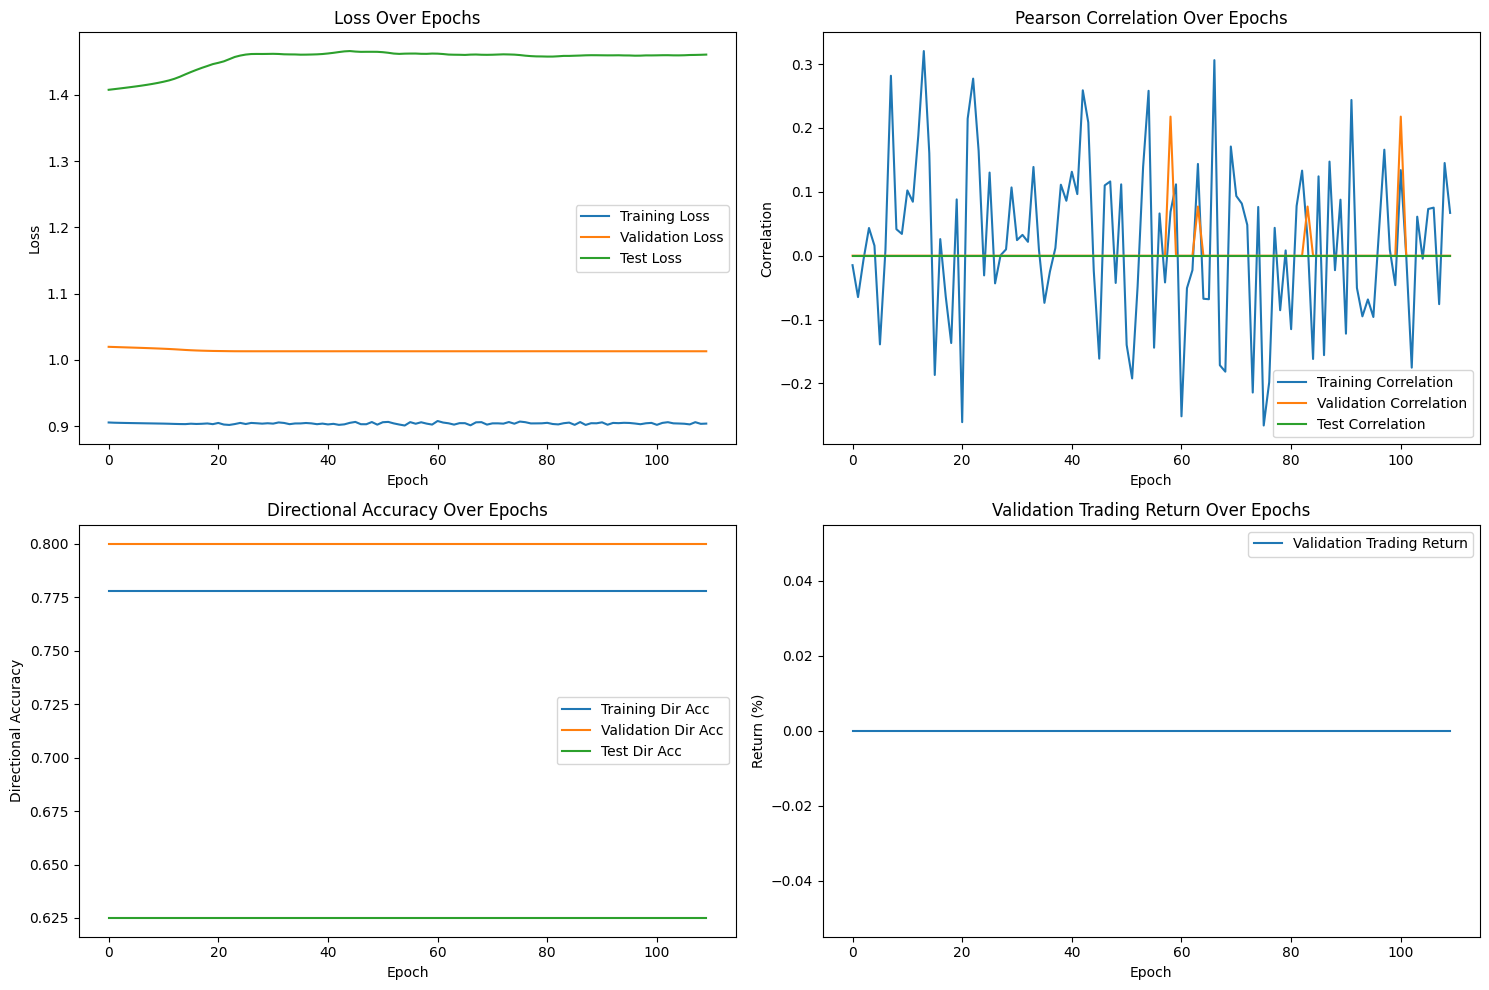

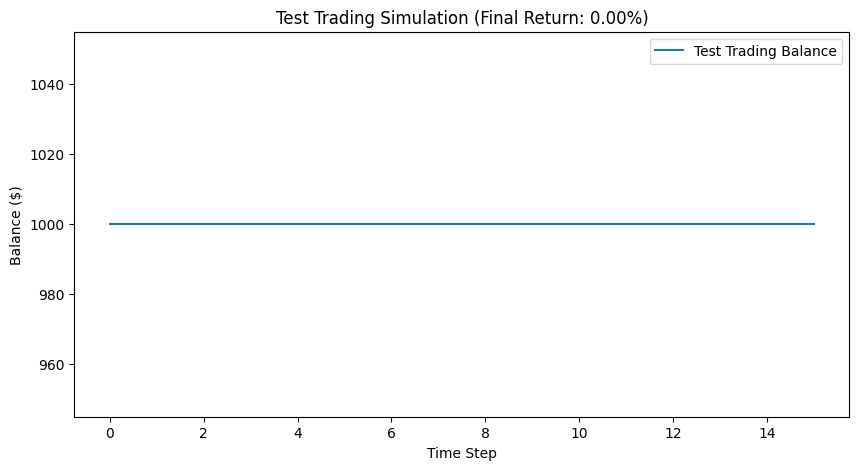

In [20]:

# ------------------------- Main Execution -------------------------


if __name__ == "__main__":
    X, y = collect_meme_coin_data(MEME_COINS, ANALYSIS_START_DATE, ANALYSIS_END_DATE)
    if len(X) == 0:
        print("No data collected, using minimal dummy data for testing")
        X = np.array([[3.0, 0.0, np.log1p(1), np.log1p(0)]] * 10)
        y = np.array([[0.0]] * 10)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    model = MrStonks()
    model.add(Layer_Dense(4, 128, weight_regularizer_l2=0.01))
    model.add(Activation_ReLU())
    model.add(Layer_Dropout(0.3))
    model.add(Layer_Dense(128, 64))
    model.add(Activation_ReLU())
    model.add(Layer_Dense(64, 32))
    model.add(Activation_ReLU())
    model.add(Layer_Dense(32, 1))
    model.add(Activation_Linear())
    model.set(
        loss=Loss_MeanSquaredError(),
        optimizer=Optimizer_Adam(learning_rate=0.001, decay=1e-4),
        accuracy=Accuracy_Regression()
    )
    model.finalize()

    model.train(X_train, y_train, X_val, y_val, X_test, y_test, epochs=200, batch_size=16, print_every=10, patience=50)